# Try to look at the vessel structure
Can we do some distance transformation magic?

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import pandas
import platform
import os
import numpy
from itkwidgets import view  # 3d viewer
import skimage
import skimage.morphology
import scipy.stats

In [2]:
# Ignore warnings in the notebook
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [4]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [5]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [6]:
# Different locations if running either on Linux or Windows
FastSSD = True
# to speed things up significantly
if 'debian' in platform.dist():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        BasePath = os.path.join('S:\\')
Root = os.path.join(BasePath, 'Tuebingen', 'Overview')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/Tuebingen/Overview


In [7]:
try:
    Data = pandas.read_pickle(os.path.join(Root, 'TuebingenDataframe.pkl'))
except FileNotFoundError:
    print('\n\nData file not found\n\n')
    print('Please run the "DisplayOverViewScans" notebook to generate it first!\n\n')

In [8]:
from datetime import datetime
print('The data file was created on %s'
      % datetime.fromtimestamp(os.stat(os.path.join(Root, 'TuebingenDataframe.pkl')).st_ctime))

The data file was created on 2020-01-14 15:11:12.591619


In [9]:
# Convert all reconstructions into a single numpy array and them to disk
# But only do this if we didn't do it already :)
# Partially based on http://stackoverflow.com/a/39195332/323100
# Since we reload/memorymap the stack below, we overwrite the variable with NaN and clear the memory
Data['OutputNameRec'] = [os.path.join(f, sample + '_rec.npy') for f, sample in zip(Data.Folder, Data.Sample)]
# Don't save into the dataframe, or else we won't be able to make it :)
Reconstructions = [numpy.nan for file in Data['OutputNameRec']]
# Do it now
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameRec']):
        print('%2s/%s: %s: Loading reconstructions from %s' % (c + 1,
                                                               len(Data),
                                                               row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                               row['OutputNameRec']))
        Reconstructions[c] = numpy.load(row['OutputNameRec'], mmap_mode='r')
    else:
        print('%2s/%s: %s: Reading %04s reconstructions' % (c + 1,
                                                            len(Data),
                                                            row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                            row['Number of reconstructions']))
        # https://groups.google.com/forum/#!topic/imageio/O3TjIWKzd5Q
        Reconstructions[c] = numpy.stack([imageio.imread(rec,
                                                         ignoregamma=True) for rec in row['Reconstructions']], 0)
        print('%s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max() + 7),
                                    row['OutputNameRec'][len(Root):]))
        numpy.save(row['OutputNameRec'], Reconstructions[c], allow_pickle=False)

 1/14:  04N: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/04N/04N_rec.npy
 2/14: 04OP: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/04OP/04OP_rec.npy
 3/14:  07N: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/07N/07N_rec.npy
 4/14: 07OP: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/07OP/07OP_rec.npy
 5/14:  10N: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/10N/10N_rec.npy
 6/14: 10OP: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/10OP/10OP_rec.npy
 7/14:  14N: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/14N/14N_rec.npy
 8/14: 14OP: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/14OP/14OP_rec.npy
 9/14:  15N: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/15N/15N_rec.npy
10/14: 15OP: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/15OP/15OP_rec.npy
11/14:  19

In [10]:
# The three cardinal directions
directions = ['Axial', 'Sagittal', 'Coronal']

In [11]:
Data.head()

,index,Folder,Sample,SampleNameLength,LogFile,Voxelsize,NumRec,Reconstructions,Number of reconstructions,OutputNameRec,Size,Mid_Axial,Mid_Sagittal,Mid_Coronal,MIP_Axial,MIP_Sagittal,MIP_Coronal
0,0,/media/habi/Fast_SSD/Tuebingen/Overview/04N,04N,3,/media/habi/Fast_SSD/Tuebingen/Overview/04N/pr...,21.603999,1767,[/media/habi/Fast_SSD/Tuebingen/Overview/04N/r...,1767,/media/habi/Fast_SSD/Tuebingen/Overview/04N/04...,"(1767, 1224, 1224)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 4, 9, 6, 5, 5, 0, 0, 0, 1, 0,...","[[0, 0, 0, 0, 0, 0, 0, 1, 3, 5, 5, 4, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 24, 24, 22, 19, 17, 17, 19, 17, ...","[[0, 0, 0, 8, 10, 9, 8, 8, 8, 10, 8, 8, 8, 7, ..."
1,1,/media/habi/Fast_SSD/Tuebingen/Overview/04OP,04OP,4,/media/habi/Fast_SSD/Tuebingen/Overview/04OP/p...,21.603999,1606,[/media/habi/Fast_SSD/Tuebingen/Overview/04OP/...,1606,/media/habi/Fast_SSD/Tuebingen/Overview/04OP/0...,"(1606, 1224, 1224)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 3, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 5, 4, 5, 4, 5,...","[[0, 0, 0, 0, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2,..."
2,2,/media/habi/Fast_SSD/Tuebingen/Overview/07N,07N,3,/media/habi/Fast_SSD/Tuebingen/Overview/07N/pr...,21.603999,1598,[/media/habi/Fast_SSD/Tuebingen/Overview/07N/r...,1598,/media/habi/Fast_SSD/Tuebingen/Overview/07N/07...,"(1598, 1224, 1224)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 1, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 3, 3, 4, 3, 4, 5, 4, 3, 3, 3,...","[[0, 0, 0, 0, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3,..."
3,3,/media/habi/Fast_SSD/Tuebingen/Overview/07OP,07OP,4,/media/habi/Fast_SSD/Tuebingen/Overview/07OP/p...,21.603999,1753,[/media/habi/Fast_SSD/Tuebingen/Overview/07OP/...,1753,/media/habi/Fast_SSD/Tuebingen/Overview/07OP/0...,"(1753, 1224, 1224)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 8, 7, 3, 3, 7, 8, 2, 0, 0, 0,...","[[0, 0, 0, 0, 0, 3, 5, 6, 8, 6, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 13, 12, 11, 12, 15, 14, 11, 9...","[[0, 0, 0, 0, 12, 21, 25, 39, 45, 41, 39, 33, ..."
4,4,/media/habi/Fast_SSD/Tuebingen/Overview/10N,10N,3,/media/habi/Fast_SSD/Tuebingen/Overview/10N/pr...,21.603999,1948,[/media/habi/Fast_SSD/Tuebingen/Overview/10N/r...,1948,/media/habi/Fast_SSD/Tuebingen/Overview/10N/10...,"(1948, 1224, 1224)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 10, 13, 17, 16, 15, 13, 18, 27, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 8, 8, 10, 8, 7, 7, 7, 8, 7, 7...","[[0, 0, 0, 0, 21, 22, 27, 27, 27, 28, 30, 30, ..."


In [12]:
# # Show MIPs together
# for d, direction in enumerate(directions):
#     print(direction)
#     for c, row in Data.iterrows():
#         plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
#         plt.imshow(row['MIP_' + direction], alpha=0.5)
#         plt.imshow(row['Mid_' + direction], cmap='viridis', alpha=0.5)
#         plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s MIP' % (c + 1,
#                                          len(Data),
#                                          row['Sample'],
#                                          direction.lower()))
#         plt.axis('off')
#         plt.savefig(os.path.join(Root, 'MIPs.' + direction + '.png'),
#                     bbox_inches='tight')
#     plt.show()

We need to do a segmentation of the vessels/bones to prepare the datasets for the distance transformation.
Since the datasets are fairls simple, we threshold them (with Otsu thresholding) globally.

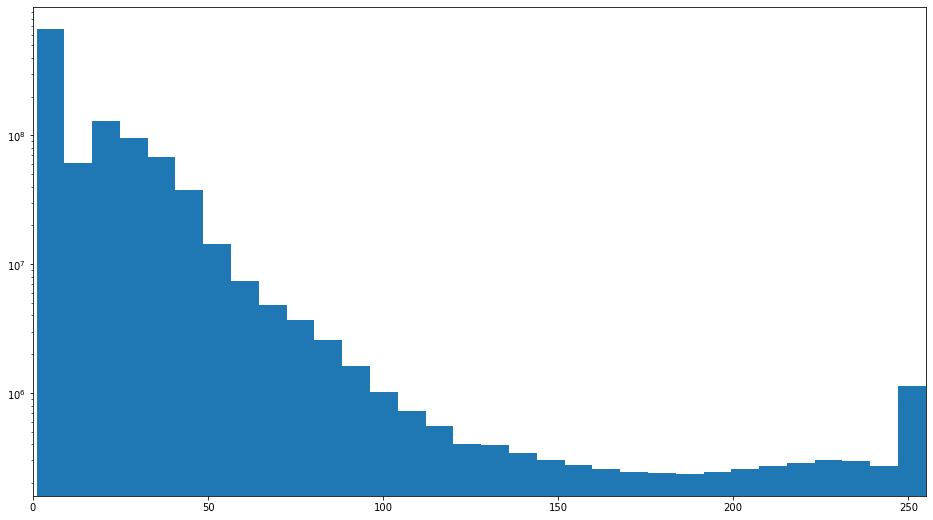

In [13]:
plt.hist(Reconstructions[1][Reconstructions[1]>0].ravel(),
         bins=32,
         log=True)
plt.xlim([0,255])
plt.show()

In [14]:
def crop_center(img, cubesize=25, verbose=True):
    '''
    Return only the central part of the stack, making our life easier.
    E.g. input a cube size and return a cube with this size from the center of the original image
    '''
    if len(numpy.shape(img)) != 3:
        print('Only works with a 3D stack')
        return()
    if verbose:
        print('The original stack has a size of %s x %s x %s px' % numpy.shape(img))
        print('We return the central %s^3 px' % cubesize)
    if int(numpy.shape(img)[0] - cubesize) < 0 or int(numpy.shape(img)[1] - cubesize) < 0 or int(numpy.shape(img)[2] - cubesize) < 0:
        print(3*'\n')
        print('You need to select a smaller "cubesize" than %s, '
              'otherwise I do not crop the image, but make it bigger' % cubesize)
        print(3*'\n')        
        return(numpy.nan)
    # Based on the given cubesize above we calculate how much we need to cut in the mean from each axis
    img_center = img[int((numpy.shape(img)[0] - cubesize) / 2):-int((numpy.shape(img)[0] - cubesize) / 2),
                     int((numpy.shape(img)[1] - cubesize) / 2):-int((numpy.shape(img)[1] - cubesize) / 2),
                     int((numpy.shape(img)[2] - cubesize) / 2):-int((numpy.shape(img)[2] - cubesize) / 2)]
    return(img_center)

In [15]:
def calculate_threshold(img, verbose=True):
    '''
    Calculate (Otsu) threshold of a stack, with some nice output if desired
    '''
    if len(numpy.shape(img)) != 3:
        print('Only works with a 3D stack')
        return()
    if verbose:
        print('The stack we use has a size of %s x %s x %s px' % numpy.shape(img))
    threshold = skimage.filters.threshold_otsu(img[img>1])
    if verbose:
        seaborn.distplot(img.ravel())
        plt.axvline(threshold, label='Otsu@%s' % threshold)
        plt.legend()
        plt.xlim([0,255])
        plt.show()
    return(threshold)

In [16]:
# Calculate Otsu threshold for *all* the reconstructions and save them to the dataframe
cubesize=200
Data['Threshold'] = [calculate_threshold(crop_center(rec,
                                                     cubesize=cubesize,
                                                     verbose=False),
                                         verbose=False) for rec in Reconstructions]
print('The mean threshold is %0.2f' % Data['Threshold'].mean())

The mean threshold is 74.64


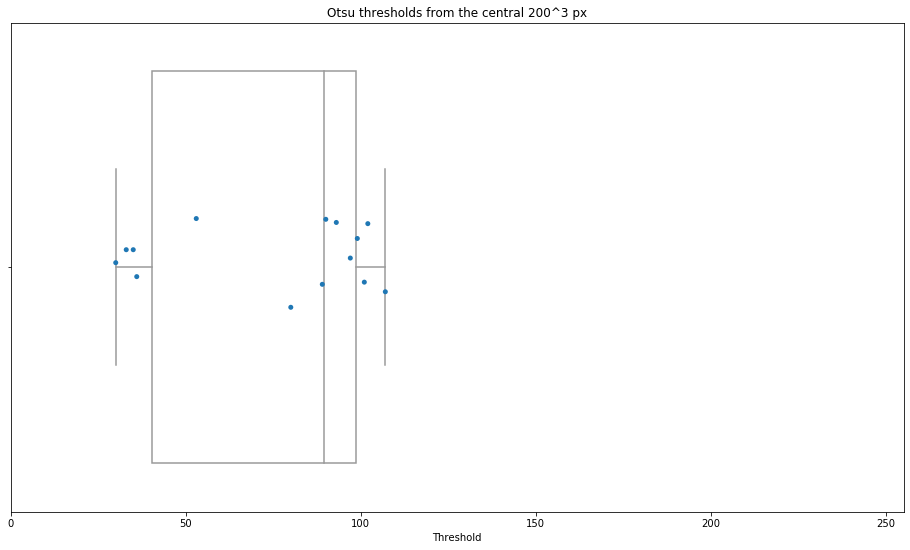

In [17]:
seaborn.boxplot(Data.Threshold, color='white')
seaborn.stripplot(Data.Threshold)
plt.xlim([0,255])
plt.title('Otsu thresholds from the central %s^3 px' % cubesize)
plt.show()

In [18]:
# Threshold datasets and save as new dataset and load them into variable
Data['OutputNameThresholded'] = [os.path.join(f,
                                              sample + '_rec_thresholded_' + str(threshold) + '.npy')
                                 for f, sample, threshold in zip(Data.Folder,
                                                                 Data.Sample,
                                                                 Data.Threshold)]
Thresholded = [numpy.nan for file in Data['OutputNameThresholded']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameThresholded']):
        print('%2s/%s: %s: Loading thresholded dataset %s' % (c + 1,
                                                              len(Data),
                                                              row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                              row['OutputNameThresholded']))
        Thresholded[c] = numpy.load(row['OutputNameThresholded'], mmap_mode='r')
    else:
        print('%2s/%s: %s: Thresholding reconstructions with %s' % (c + 1,
                                                                    len(Data),
                                                                    row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                                    row['Threshold']))
        Thresholded[c] = Reconstructions[c] > row['Threshold']
        print('%s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max() + 7),
                                    row['OutputNameThresholded'][len(Root):]))
        numpy.save(row['OutputNameThresholded'], Thresholded[c], allow_pickle=False)

 1/14:  04N: Loading thresholded dataset /media/habi/Fast_SSD/Tuebingen/Overview/04N/04N_rec_thresholded_90.npy
 2/14: 04OP: Loading thresholded dataset /media/habi/Fast_SSD/Tuebingen/Overview/04OP/04OP_rec_thresholded_30.npy
 3/14:  07N: Loading thresholded dataset /media/habi/Fast_SSD/Tuebingen/Overview/07N/07N_rec_thresholded_97.npy
 4/14: 07OP: Loading thresholded dataset /media/habi/Fast_SSD/Tuebingen/Overview/07OP/07OP_rec_thresholded_80.npy
 5/14:  10N: Loading thresholded dataset /media/habi/Fast_SSD/Tuebingen/Overview/10N/10N_rec_thresholded_35.npy
 6/14: 10OP: Loading thresholded dataset /media/habi/Fast_SSD/Tuebingen/Overview/10OP/10OP_rec_thresholded_53.npy
 7/14:  14N: Loading thresholded dataset /media/habi/Fast_SSD/Tuebingen/Overview/14N/14N_rec_thresholded_89.npy
 8/14: 14OP: Loading thresholded dataset /media/habi/Fast_SSD/Tuebingen/Overview/14OP/14OP_rec_thresholded_101.npy
 9/14:  15N: Loading thresholded dataset /media/habi/Fast_SSD/Tuebingen/Overview/15N/15N_rec_th

In [19]:
view(Thresholded[0].astype('uint8'))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC3; proxy …

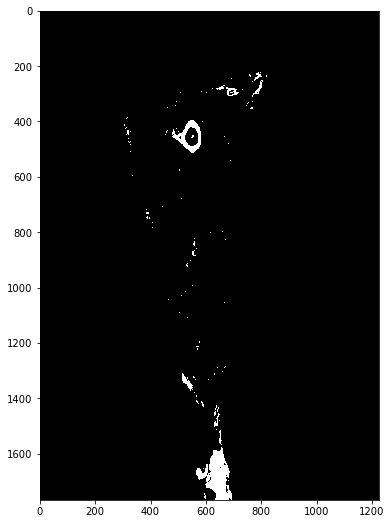

In [20]:
plt.imshow(Thresholded[0][:,:,500])

In [21]:
# Distance transformation
edt = scipy.ndimage.morphology.distance_transform_edt(crop_center(Thresholded[0], cubesize=333))
# plt.imshow(scipy.ndimage.morphology.distance_transform_edt(Thresholded[1][:,:,25][200:-400,550:-150]), cmap='viridis')

The original stack has a size of 1767 x 1224 x 1224 px
We return the central 333^3 px


The original stack has a size of 1767 x 1224 x 1224 px
We return the central 333^3 px


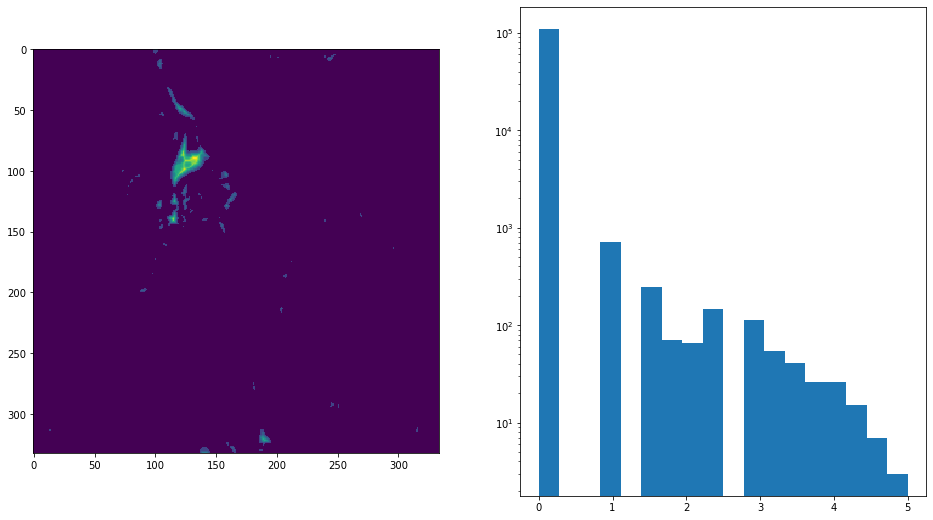

In [22]:
detail = edt[:,:,150]
img_crop = crop_center(Thresholded[0], cubesize=333)[:,:,150]
plt.subplot(121)
plt.imshow(detail, cmap='viridis')
plt.subplot(122)
plt.hist(detail.ravel(), bins='auto', log=True)
plt.show()

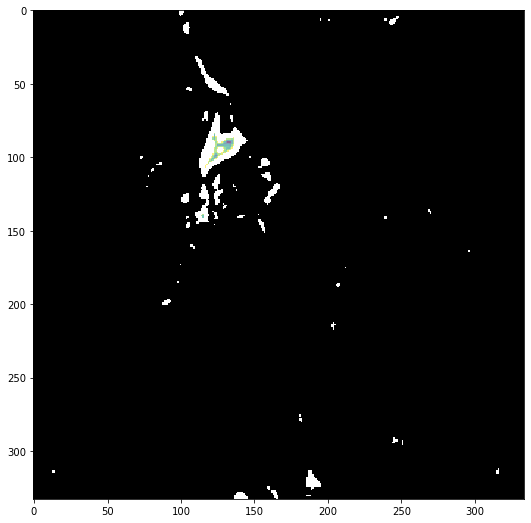

In [23]:
plt.imshow(img_crop)
plt.imshow(numpy.ma.masked_inside(detail, -0.01,3.3), cmap='viridis_r', alpha=0.6)

We should do some skeletonization and then get a histogram of it.
Probably we should also see if we can exclude the bone!

In [24]:
# Skeletonization with skimage
# https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.skeletonize_3d
import skimage.morphology

In [25]:
which=1
shave=750
img = Reconstructions[which][shave:-shave,int(shave/2):-int(shave/2),int(shave/2):-int(shave/2)]
thresh = Thresholded[which][shave:-shave,int(shave/2):-int(shave/2),int(shave/2):-int(shave/2)]
numpy.shape(img)

(106, 474, 474)

# An idea
- Fill the bones (with something like `skimage.fill.small.holes`)
    This doesn't seem to be working in the 3D case (maybe because of small holes in the bone) but we just loop through every slice and do it for each and everyone of it. This is bad code, but works :)
- Remove all the bones (with `tophat`), or remove all the big stuff from the segmentation (how big?)
- Calculate the distance-transformation or skeleton

In [26]:
def ourfiller(image, verbose=False):
    '''
    Since we cannot seem to get remove_small_holes to work in 3D, we simply brute-force it on every slice.
    And generate an output array afterwards.
    '''
    filled = numpy.asarray([skimage.morphology.remove_small_holes(s, area_threshold=1e4) for s in center])
    if verbose:
        plt.subplot(131)
        plt.imshow(image[len(filled)//2,:,:])
        plt.title('original')
        plt.subplot(132)
        plt.imshow(filled[len(filled)//2,:,:])       
        plt.title('filled (output)')
        plt.subplot(133)        
        plt.imshow(image[len(filled)//2,:,:], alpha=0.5)       
        plt.imshow(filled[len(filled)//2,:,:], cmap='viridis', alpha=0.5)       
        plt.title('overlay')        
        plt.show()    
    return(filled)

In [27]:
# def pad_edges(image, howmanypixels=25):
#     '''There *has* to be a better way to set the edges to one, but I havent found one'''
#     closed = image.copy()
#     closed[:howmanypixels,:,:] = True
#     closed[:,:howmanypixels,:] = True
#     closed[:,:,:howmanypixels] = True
#     closed[-howmanypixels:,:,:] = True
#     closed[:,-howmanypixels:,:] = True
#     closed[:,:,-howmanypixels:] = True
#     return(closed)

In [28]:
# def fill_hollow_bones(image, verbose=False):
#     '''
#     We flood-fill the image from one edge.
#     Then we add the inversion of this to the original image and thus filled all the long bones.
#     '''
#     dilated = skimage.morphology.binary_dilation(
#         skimage.morphology.binary_dilation(
#             skimage.morphology.binary_dilation(image)))
#     closed = pad_edges(dilated)
#     # Flood fill from one edge and invert the (boolean) result
#     flooded = ~skimage.morphology.flood_fill(closed.astype('int'),
#                                              seed_point=(30,30,30),
#                                              new_value=1).astype('bool')
#     # Add the inverted result to the original image, filling the long bones
#     filled = numpy.add(image, skimage.morphology.binary_dilation(
#         skimage.morphology.binary_dilation(
#             skimage.morphology.binary_dilation(flooded))))
#     if verbose:
#         plt.subplot(131)
#         plt.imshow(image[len(filled)//2,:,:])
#         plt.title('original')
#         plt.subplot(132)
#         plt.imshow(flooded[len(filled)//2,:,:])       
#         plt.title('flooded')
#         plt.subplot(133)        
#         plt.imshow(image[len(filled)//2,:,:], alpha=0.5)       
#         plt.imshow(filled[len(filled)//2,:,:], cmap='viridis', alpha=0.5)       
#         plt.title('filled (output)')        
#         plt.show()
#     return(filled)

In [29]:
center = crop_center(Thresholded[0], cubesize=350)

The original stack has a size of 1767 x 1224 x 1224 px
We return the central 350^3 px


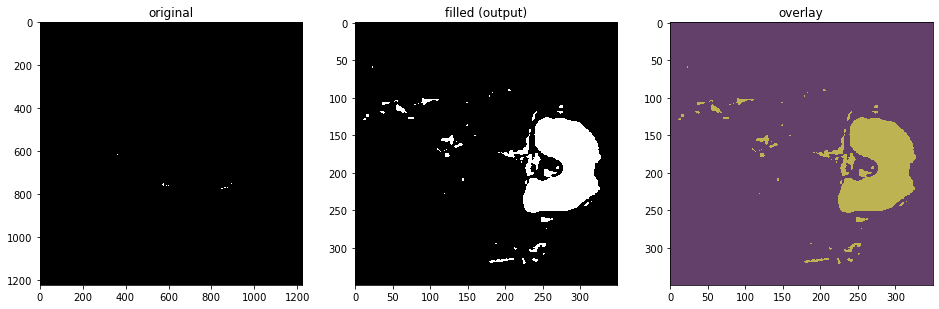

In [30]:
flooded = ourfiller(Thresholded[0], verbose=True)

In [31]:
# get the white tophat
# https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.white_tophat
# e.g. the bright spots of the image that are smaller than the structuring element.
# We use a ball-shaped (sphere) structuring element
tophat = skimage.morphology.white_tophat(flooded,selem=skimage.morphology.ball(7))

0 Axial


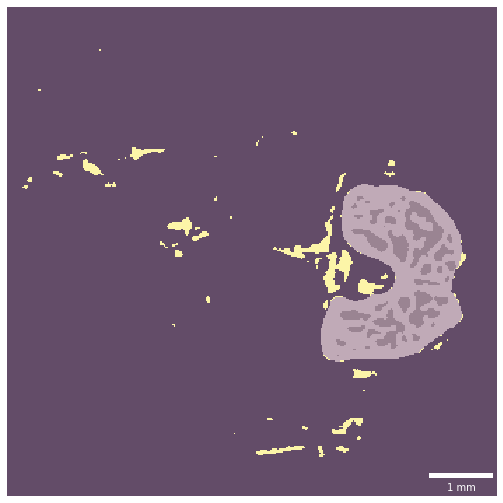

1 Sagittal


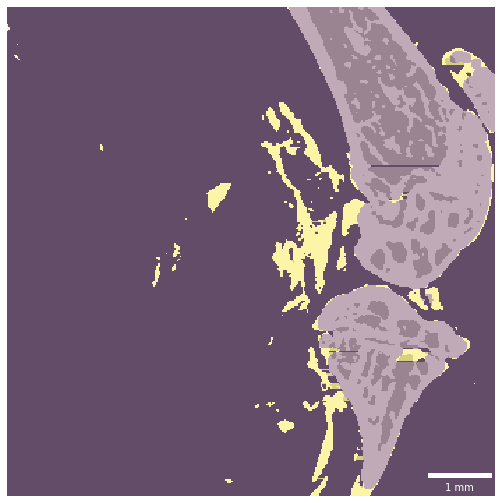

2 Coronal


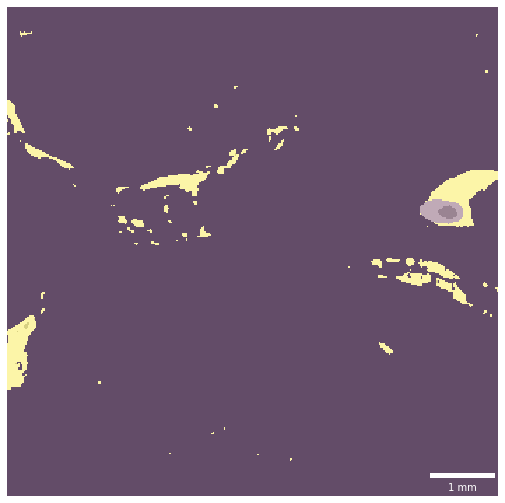

In [120]:
for c, direction in enumerate(directions):
    print(c, direction)    
    if c:
        plt.imshow(numpy.rot90(center, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33)
        plt.imshow(numpy.rot90(flooded, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33, cmap='magma')
        plt.imshow(numpy.rot90(tophat, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33, cmap='viridis')
    else:
        plt.imshow(center[len(flooded)//2,:,:], alpha=0.33)
        plt.imshow(flooded[len(flooded)//2,:,:], alpha=0.33, cmap='magma')
        plt.imshow(tophat[len(flooded)//2,:,:], alpha=0.33, cmap='viridis')
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0], 'um'))
    plt.axis('off')
    plt.savefig('Overlay-%s.png' % direction, bbox_inches='tight')  
    plt.show()

In [35]:
# ball = skimage.morphology.selem.ball(50)
# test = numpy.pad(ball, 50)

In [121]:
# Calculate the skeleton and the euclidean distance transformation
# By multiplying them later on we get a color-coded medial axis transformation
# This conforms to what we would expect from 'skimage.morphology.medial_axis(image, return_distance=True)' which does *not* work for 3D images
skeleton = skimage.morphology.skeletonize_3d(tophat)
distance = scipy.ndimage.morphology.distance_transform_edt(tophat)

In [122]:
skeldist = skeleton * distance

In [140]:
len(Data)

14

0 Axial


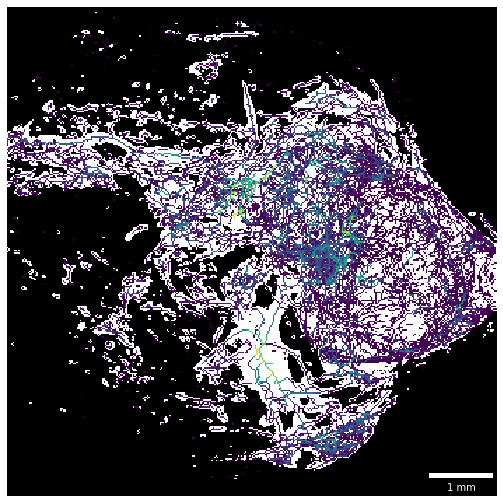

1 Sagittal


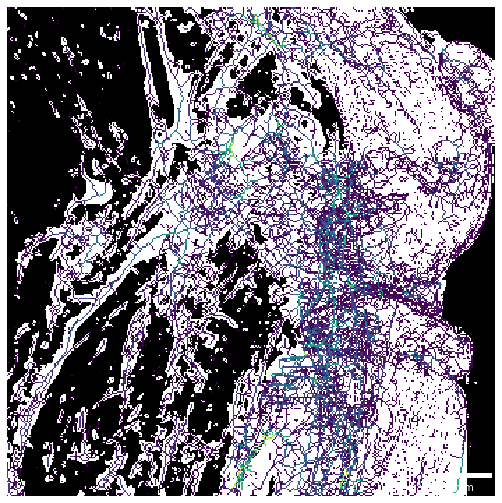

2 Coronal


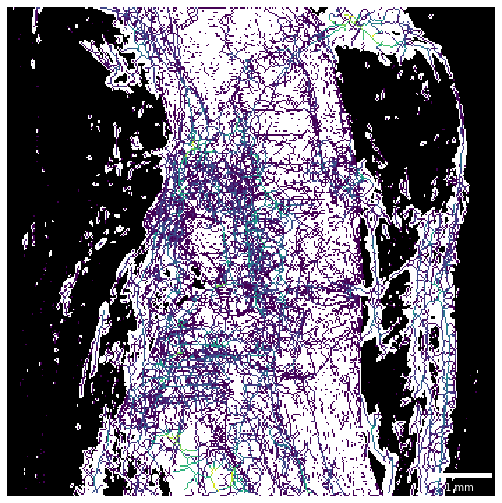

In [139]:
for c, direction in enumerate(directions):
    print(c, direction)
    plt.imshow(numpy.max(center, axis=c))
    plt.imshow(numpy.max(numpy.ma.masked_less(skeldist, 1), axis=c), cmap='viridis')
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0], 'um'))
    plt.axis('off')
    plt.savefig('Skeletonization-MIP-%s.png' % direction, bbox_inches='tight')  
    plt.show()

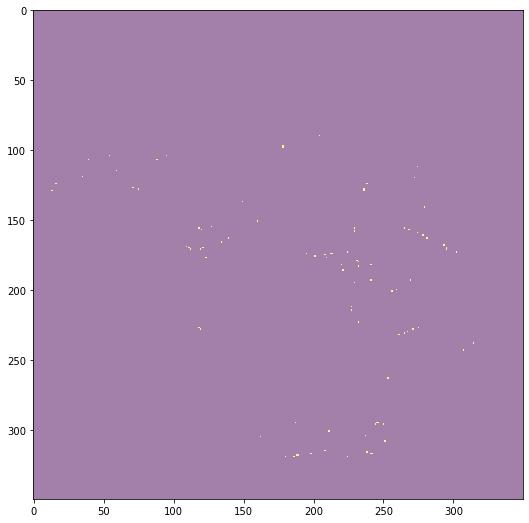

In [76]:
# plt.imshow(flooded[len(flooded)//2,:,:], alpha=0.5)
plt.imshow(skeleton[len(flooded)//2,:,:], alpha=0.5, cmap='viridis')

In [79]:
numpy.unique(skeldist)

array([   0.        ,  255.        ,  360.62445841,  441.67295593,
        510.        ,  570.19733426,  624.61988441,  721.24891681,
        765.        ,  806.38080334,  845.73932154,  883.34591186,
        919.41557524,  954.12263363, 1020.        , 1051.39193453,
       1081.87337522, 1111.5192306 , 1140.39466852, 1168.55680221,
       1196.05601875, 1249.23976882, 1275.        , 1300.24997597,
       1325.01886779, 1373.21702582, 1396.69252164, 1442.49783362,
       1464.86347487, 1486.89273319, 1508.60034469, 1530.        ,
       1551.10444523, 1571.92557076, 1612.76160669, 1632.79668055,
       1652.58887809, 1710.59200279])

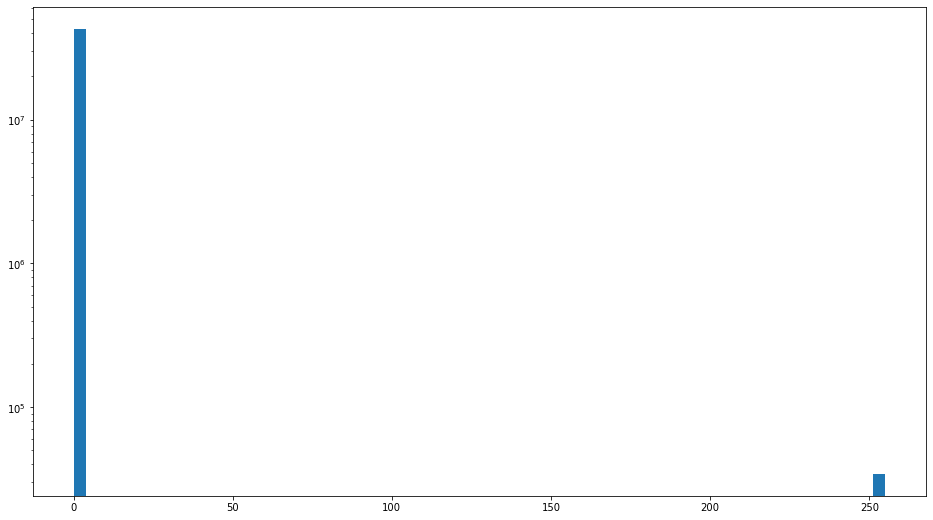

In [77]:
plt.hist(skeleton.ravel(), bins=64, log=True)
plt.show()

In [ ]:
numpy.shape(skeleton)

In [ ]:
whichslice=55
plt.subplot(221)
plt.imshow(img[whichslice,:,:])
plt.title('Original')
plt.subplot(222)
plt.imshow(thresh[whichslice,:,:])
plt.imshow(tophat[whichslice,:,:], cmap='viridis', alpha=0.5)
plt.title('Thresholded with input for skeletonization (tophat: yellow)')
plt.subplot(223)
plt.imshow(tophat[whichslice,:,:])
plt.imshow(skeleton[whichslice,:,:], cmap='viridis', alpha=0.5)
plt.title('Input for skeletonization (purple) with skeleton (yellow)')
plt.subplot(224)
plt.imshow(skeleton[whichslice,:,:])
plt.show()

In [ ]:
plt.imshow(numpy.max(skeleton, axis=2))
plt.show()

In [ ]:
asdfasdf==skeleton

In [ ]:
import numpy as np
from scipy import ndimage as ndi
from skimage.morphology import medial_axis
import matplotlib.pyplot as plt


def microstructure(l=256):
    """
    Synthetic binary data: binary microstructure with blobs.

    Parameters
    ----------

    l: int, optional
        linear size of the returned image

    """
    n = 5
    x, y = np.ogrid[0:l, 0:l]
    mask = np.zeros((l, l))
    generator = np.random.RandomState(1)
    points = l * generator.rand(2, n**2)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndi.gaussian_filter(mask, sigma=l/(4.*n))
    return mask > mask.mean()

data = microstructure(l=64)

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(data, return_distance=True)

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.imshow(data)
ax1.axis('off')
ax2.imshow(dist_on_skel, cmap='viridis')
ax2.contour(data, [0.5], colors='w')
ax2.axis('off')

fig.tight_layout()
plt.show()

In [ ]:
BW = thresh[50,:,:]
plt.imshow(BW)
plt.show()

In [ ]:
# BW = 1 - BW
M,N = BW.shape
'''Calculating Euclidean Distance of the Binary Image'''
D,IDX = morph.distance_transform_edt(BW,return_distances=True, return_indices=True)
D = mat2gray(D)
X,Y = np.meshgrid(range(N),range(M))
delD_x = -(IDX[1,:,:] - X)
delD_y = -(IDX[0,:,:] - Y)
# normalize the derivatives
delD_norm = np.sqrt(pow(delD_x,2) + pow(delD_y,2))
with np.errstate(divide='ignore',invalid='ignore'):
    delD_xn   = delD_x / delD_norm
    delD_yn   = delD_y / delD_norm

mir_delD_xn  = mirrorBW(delD_xn)
mir_delD_yn  = mirrorBW(delD_yn)

f, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(10,30))
ax1.imshow(D)
ax1.set_title('Euclidean Distance Transform')
ax2.imshow(delD_x)
ax2.set_title('X direction of the gradient of EDT')
ax3.imshow(delD_y)
ax3.set_title('Y direction of the gradient of EDT')
plt.tight_layout()
plt.show()

In [ ]:
#Calculate flux map
fluxMap = flux(mir_delD_xn,mir_delD_yn)
plt.imshow(np.nan_to_num(fluxMap))
plt.title('Flux Map')
plt.show()

In [ ]:
#Calculate flux map
fluxMap = flux(mir_delD_xn,mir_delD_yn)
# Calculate flux threshold
fluxBWThreshold = (np.nanmax(fluxMap) - np.nanmean(fluxMap)) * 0.15 + np.nanmean(fluxMap)
with np.errstate(divide='ignore',invalid='ignore'):
    fluxThin = thin(fluxMap>fluxBWThreshold)

fluxLabeled,b = ndimage.label(fluxThin, np.array([[1,1,1], [1,1,1], [1,1,1]]))
labels ,pixelSize = np.unique(fluxLabeled,return_counts=True)
# Excluding the background
pixelSize = pixelSize[labels != 0]
labels = labels[labels != 0]
# Calculating the size threshold and filter out small objects
th = min(np.mean(pixelSize) + 3 * np.std(pixelSize), np.max(pixelSize))
selectedObjects = labels[np.where(pixelSize >= th)]

fluxTemp = np.zeros(fluxMap.shape)
fluxTemp[fluxLabeled == 1] = 1
plt.imshow(fluxTemp,cmap='gray')
plt.title('Initial Skeleton with branches')
plt.tight_layout()
plt.show()

In [ ]:
viewer = napari.view_image(data.moon())

In [ ]:
asdfasdf==

Try to filter out the vessels with a [`Frangi` vesselness filter](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.frangi).
It is *slow*!

In [ ]:
shift = 200
crop = Reconstructions[9][700:-700,350+shift:-350+shift,350+shift:-350+shift]

In [ ]:
numpy.shape(crop)

In [ ]:
vessels = skimage.filters.frangi(crop)

In [ ]:
view((vessels*100000).astype('uint8'))

In [ ]:
numpy.shape(vessels)

In [ ]:
numpy.shape(crop)

In [ ]:
numpy.max(vessels*1000)

In [ ]:
plt.subplot(121)
plt.imshow(numpy.max(crop, axis=1))
plt.subplot(122)
plt.imshow(numpy.max(vessels, axis=1), vmax=1e-5)

In [ ]:
import numpy
numpy.ones((5,5))

In [ ]:
a = numpy.reshape(numpy.arange(25), (5,5))

In [ ]:
a

In [ ]:
numpy.clip(a,5,13)

In [ ]:
plt.imshow(a)